 $ GRAPPA \newline
 \boldsymbol{G}ene\boldsymbol{R}alized \boldsymbol{A}utocalibrating \boldsymbol{P}artial \boldsymbol{P}arallel \boldsymbol{A}quisitions $

In [1]:
using Distributions
using Random
using PyPlot
using FFTW
using Images
using Base
using LinearAlgebra
using DSP

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1260


<img src="pics/GRAPPA1.png">

*GRAPPA method corrects and then reconstructs*

**Data Aquisition**


<img src="pics/GRAPPA2.png">

**Parallel Imaging**
- item undersampling k space in phase encoding direction: not fully 360 degree, but keep the echo
- item faster acquisition 
- spartial aliasing
- central oversampling
- every coil just 50 \% for two coils?

In [2]:
#create meshgrid
X = ones(500,500);
Y = ones(500,500);
for i=1:500
    X[:,i] = X[:,i].*i;
    Y[i,:] = Y[i,:].*i;
end

Here I create a dummy sensiticity map with a multivariate gaussian distribution, to demonstrate a GRAPPA reconstruction with a two coil data aquisition

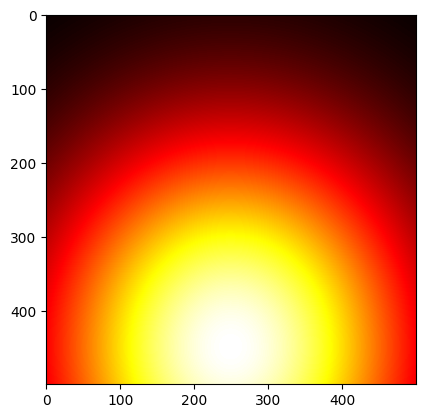

In [3]:
# First sensitivity map for the bottom coil
gausX = pdf.(Normal(250,180),X) #muX = 250 std 180
gausY = pdf.(Normal(450,200),Y); #muY=450 std=200
gaus = gausX.*gausY;
imshow(gaus, cmap="hot");

In [4]:
fourier = FFTW.fft(gaus) ;
fshift = FFTW.fftshift(fourier)
magnitude =  log.(abs.(fshift));

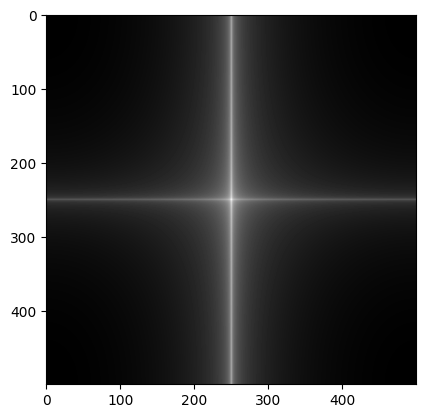

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d5a1910>

In [5]:
imshow(magnitude, cmap="gray")

In [6]:
N = 500
shepp = shepp_logan(N, highContrast=true);

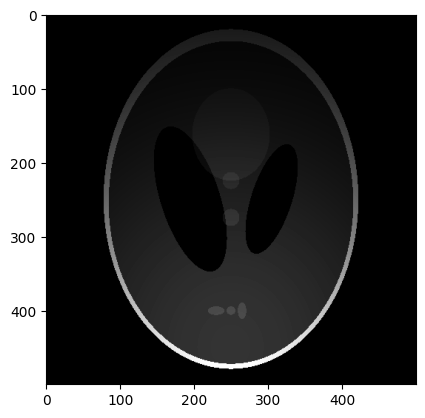

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d551af0>

In [7]:
imshow(shepp.*gaus, cmap="gray")

In [8]:
fourier = FFTW.fft(shepp.*gaus) ;
fshift = FFTW.fftshift(fourier)
magnitude =  log.(abs.(fshift));

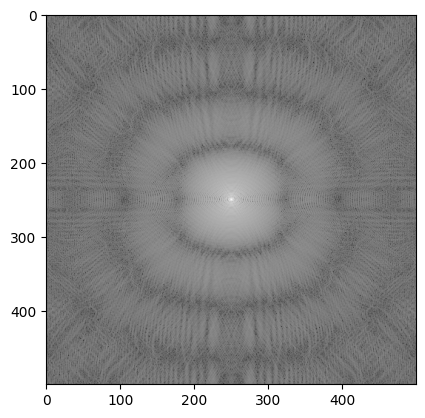

In [9]:
imshow(magnitude, cmap="gray");

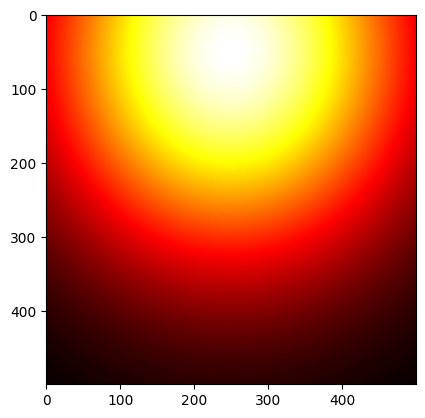

In [10]:
# First sensitivity map for the bottom coil
gausX2 = pdf.(Normal(250,180),X)
gausY2 = pdf.(Normal(50,200),Y);
gaus2 = gausX2.*gausY2;
imshow(gaus2, cmap="hot");

In [11]:
fourier_shepp = FFTW.fft(shepp) ;
fshift_shepp = FFTW.fftshift(fourier_shepp)
magnitude =  log.(abs.(fshift_shepp));

**Sampling Pattern**

| $\bullet$ 	| $\bullet$ 	| $\bullet$ 	| $\bullet$ 	| aquired   	|
|-----------	|-----------	|-----------	|-----------	|-----------	|
| $\circ$   	| $\circ$   	| $\circ$   	| $\circ$   	| unaquired 	|
| $\bullet$ 	| $\bullet$ 	| $\bullet$ 	| $\bullet$ 	| aquired   	|
| $\circ$   	| $\circ$   	| $\circ$   	| $\circ$   	| unaquired 	|

In [12]:
k_coil1 = FFTW.fftshift(FFTW.fft(shepp.*gaus));
k_coil2 = FFTW.fftshift(FFTW.fft(shepp.*gaus2));

Iterate through the autocalibration signal and define the training samples for the GRAPPA weights

In [13]:
X_train = zeros(ComplexF64, (12,71*498));
y_train = zeros(ComplexF64, (71*498,2));
idx = 1;
for z=210:280
    for p=2:499
        a,b,c = k_coil1[z-1, [p-1,p,p+1]]
        d,e,f = k_coil1[z+1, [p-1,p,p+1]]
        g,h,i = k_coil2[z-1, [p-1,p,p+1]]
        j,k,l = k_coil2[z+1, [p-1,p,p+1]]
        X_train[:,idx] = [a,b,c,d,e,f,g,h,i,j,k,l]
        y_train[idx,:] = [k_coil1[z,p] ; k_coil2[z,p]]
        idx +=1;
    end
end

In [14]:
@show size(X_train)
@show size(y_train);

size(X_train) = (12, 35358)
size(y_train) = (35358, 2)


The Kernel weigths are computed in a least squares sense with the pseudoinverse. The first column refers to the first column and the second column to the second coil respectively.

In [15]:
W = pinv(X_train)' *y_train

12×2 Array{Complex{Float64},2}:
 -0.0536713+0.0373614im   -0.147897+0.0480404im
  -0.216045-0.308906im    0.0738287-0.692369im
 -0.0559458+0.0427069im   -0.138113+0.0692152im
 -0.0546796-0.0382261im   -0.132206-0.0709626im
  -0.211836+0.314057im    0.0842776+0.666012im
 -0.0515118-0.0326045im   -0.139655-0.0474879im
  -0.107235-0.0322235im  -0.0655074-0.0478129im
 -0.0757258+0.460759im    -0.308117+0.330845im
 -0.0974945-0.0280643im  -0.0689501-0.0566703im
 -0.0994206+0.025922im   -0.0695855+0.0626607im
 -0.0822195-0.473244im     -0.31376-0.316803im
  -0.111036+0.0304033im  -0.0678139+0.0529444im

In [ ]:
sum(isless.(abs.(k_coil2) , 1e-5 ))

In [ ]:
maximum(abs.(k_coil1))

Set every second column in the kspace data of the coils to zero, to demonstrate the aliasing effect and the GRAPPA reconstruction afterwards.

In [16]:
for i=2:499
    if mod(i,2) == 0 && abs(i-250)> 60
    fshift_shepp[i,:] = zeros(1,500)
    magnitude[i,:] = zeros(1,500)
    k_coil1[i,:]= zeros(1,500)
    k_coil2[i,:]= zeros(1,500)
        
    end
end
    
aliased_shepp = abs.(ifft(fshift_shepp));

Compute the missing kspace data with the GRAPPA weights and the aquired data points from both coils.

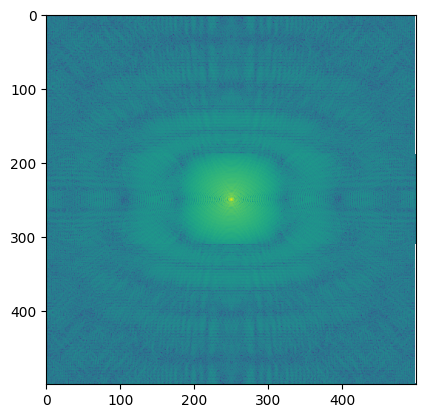

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d353310>

In [19]:
for q=2:499
    for r=2:499
        if mod(q,2) == 0 && abs(q-250)> 60
            a,b,c = k_coil1[q-1,[r-1,r,r+1]]
            d,e,f = k_coil1[q+1,[r-1,r,r+1]]            
            g,h,i = k_coil2[q-1,[r-1,r,r+1]]
            j,k,l = k_coil2[q+1,[r-1,r,r+1]]
            
            k_coil1[q,r] = W[:,1]' * [a;b;c;d;e;f;g;h;i;j;k;l];
            k_coil2[q,r] = W[:,2]' * [a;b;c;d;e;f;g;h;i;j;k;l];
         
            #print(coil1_recon[q,r], coil2_recon[q,r], "\n")
        end
    end
end
#log.(abs.(k_coil1))
imshow(log.(abs.(k_coil1)))

Individual coil images, which are merged with a sum of squares to get the final reconstruction

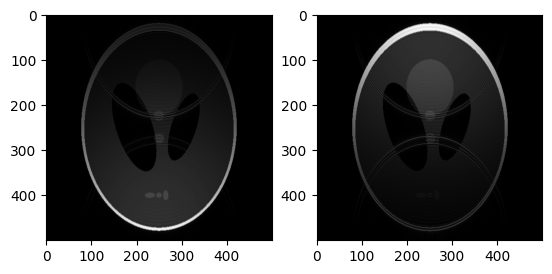

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d3538e0>

In [20]:
recon_coil1 = abs.(ifft(k_coil1))
recon_coil2 = abs.(ifft(k_coil2))
fig, (ax1, ax2) = subplots(1,2)
ax1.imshow(recon_coil1, cmap="gray")     
ax2.imshow(recon_coil2, cmap="gray")  



In [21]:
final_reconstruction = sqrt.(recon_coil1.^2 .+ recon_coil2.^2);

In [22]:
sqrt(sum(shepp.^2 .- final_reconstruction.^2))

123.48623404977445

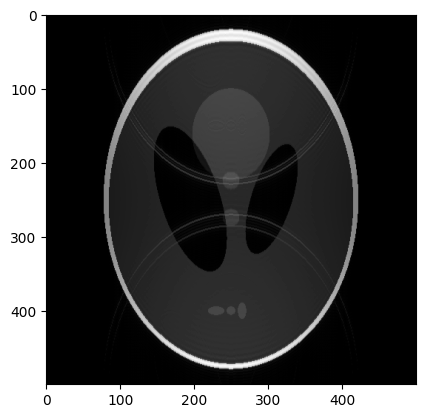

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d2399d0>

In [23]:
imshow(final_reconstruction, cmap="gray")

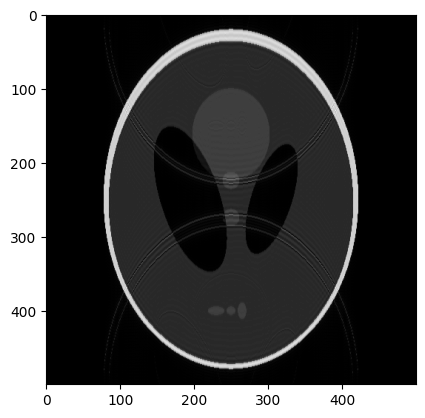

PyObject <matplotlib.image.AxesImage object at 0x7f6c3d20e2e0>

In [24]:
imshow(aliased_shepp, cmap="gray");

As you can see, the reconstruction has still aliasing artifacts, which can be removed by the following improvements
- Tikhonov Regularization
- iterative GRAPPA with gradient descent